<a href="https://colab.research.google.com/github/erika0915/artificial-intelligence/blob/main/mlp/05_optimizer_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimizer 변경 실험
- 모델 구조 : 512 유닛 MLP
- 활성화 함수 : Sigmoid
- 옵티마이저 : Adam
- 학습률 : 0.1

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.95MB/s]


[Epoch  1] Loss: 1.0102
[Epoch  2] Loss: 0.8823
[Epoch  3] Loss: 0.9125
[Epoch  4] Loss: 0.8349
[Epoch  5] Loss: 0.7387
[Epoch  6] Loss: 0.7666
[Epoch  7] Loss: 0.7652
[Epoch  8] Loss: 0.7948
[Epoch  9] Loss: 0.7715
[Epoch 10] Loss: 0.8193

총 학습 시간: 247.25초
Test Loss: 0.7173 | Accuracy: 83.94%


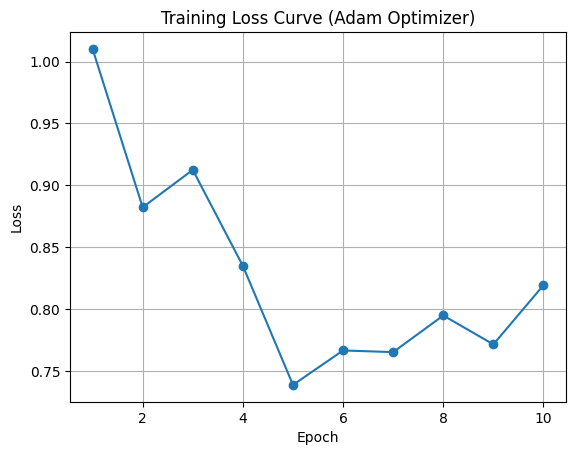

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. 데이터 전처리 & 로더
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=1000, shuffle=False)

# 2. best-performing MLP 구조 사용 (512 유닛)
class MLP512(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP512().to(device)


# 3. 학습 설명
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)  # ← 변경된 부분
epochs = 10
loss_history = []
start_time = time.time()

# 4. 학습
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(trainloader.dataset)
    loss_history.append(epoch_loss)
    print(f"[Epoch {epoch+1:2d}] Loss: {epoch_loss:.4f}")

total_time = time.time() - start_time
print(f"\n총 학습 시간: {total_time:.2f}초")

# 5. 테스트 평가
model.eval()
test_loss, correct = 0.0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

test_loss /= len(testloader.dataset)
accuracy = correct / len(testloader.dataset) * 100
print(f"Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

# 6. 시각
plt.figure()
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title('Training Loss Curve (Adam Optimizer)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
